# Noise in abstractive summarization

Предполагаемый пайплайн:
1. AESLC BERT (берт, unsupervised (на MLM task) дообученный на AESLC) --> эмбеддинги входных текстов (видимо, как усреденные пословные)
2. На полученных примерах считаем центроиды и ков. матрицу
3. Считаем расстояние Махаланобиса от центроидов 
4. Откидываем далекие примеры по трешхолду
5. Пересчитываем центроиды и ков. матрицу
6. Повторяем 2-6, пока центроиды меняются
7. Переучивыем модель для суммаризации на данных без выбросов и замеряем качество

In [1]:
%env WANDB_PROJECT=noise-in-abs-sum

import os
import warnings

warnings.filterwarnings('ignore')
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["WANDB_PROJECT"] = "noise-in-abs-sum"
CACHE_DIR_PATH = "/home/vakarlov/hf-cache-dir"

env: WANDB_PROJECT=noise-in-abs-sum


## Loading dataset

In [2]:
# ! pip install -r requirements.txt --quiet

In [3]:
# ! pip install datasets --quiet
# ! pip install transformers --quiet
# ! pip install evaluate --quiet

In [4]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = "aeslc"
raw_data = load_dataset(dataset_name, cache_dir=CACHE_DIR_PATH)

if dataset_name == "aeslc":
    raw_data = raw_data.rename_column("email_body", "text").rename_column("subject_line", "summary")
elif dataset_name == "xsum":
    raw_data = raw_data.rename_column("document", "text")
else:
    raise NotImplementedError('Unknown dataset')

Using the latest cached version of the module from /home/vakarlov/.cache/huggingface/modules/datasets_modules/datasets/aeslc/8d562772daa49c77ba4d77fbf90713819698774c172092c9aa9e7d3fb642d9ba (last modified on Wed Apr  5 08:29:23 2023) since it couldn't be found locally at aeslc.
Found cached dataset aeslc (/home/vakarlov/hf-cache-dir/aeslc/default/1.0.0/8d562772daa49c77ba4d77fbf90713819698774c172092c9aa9e7d3fb642d9ba)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame()
df['text'] = raw_data['train']['text']
df['summary'] = raw_data['train']['summary']

df

,text,summary
0,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement
1,Phillip & Keith Attached is the first draw re...,Bishops Corner
2,Your Internet Banking accounts are now setup a...,Internet Banking
3,To our IBS Customers that are still hanging in...,Internet Banking
4,Phillip Good Morning!\nI hope you had a wonder...,SMEs for expert stories
...,...,...
14431,This email is acknowledgement from the Power P...,Power Pool
14432,This email is acknowledgement from the Power P...,Power Pool of Alberta
14433,"John, Further to the voice message that I lef...",Enron Security
14434,Make sure that all curves are downloaded by th...,Simulation Curves


# Filtration

## Extracting embeddings

In [6]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('Aktsvigun/bert-base-' + dataset_name)
model = AutoModelForMaskedLM.from_pretrained("Aktsvigun/bert-base-" + dataset_name,
                                             output_hidden_states=True)

In [7]:
# # SMALL EXAMPLE 

# text_embeddings = torch.Tensor([]).reshape(0, 768)

# model.eval()
# sentences = [ 
#               "Hello I'm a single sentence",
#               "And another sentence",
#               "And the very very last one",
#               "Hello I'm a single sentence",
#               "And another sentence",
#               "And the very very last one",
#               "Hello I'm a single sentence",
#               "And another sentence",
#               "And the very very last one",
#             ]

# batch_size = 4  
# for idx in range(0, len(sentences), batch_size):
#     batch_att_masks = torch.Tensor([]).reshape(0, 50)
#     batch = sentences[idx : min(len(sentences), idx+batch_size)]
    
#     encoded = tokenizer(batch, max_length=50, padding='max_length', truncation=True)
#     batch_att_masks = torch.cat((batch_att_masks, torch.Tensor(encoded['attention_mask'])))
#     encoded = {key:torch.LongTensor(value) for key, value in encoded.items()}

#     with torch.no_grad():
#         outputs = model(**encoded)
#         last_hidden_state = outputs.hidden_states[-1]
#         # print(last_hidden_state.shape)
#         # text_embeddings.append(torch.squeeze(torch.mean(last_hidden_state, axis=1), dim=0))
#         # text_embeddings.append(torch.mean(last_hidden_state, axis=1))

#         # без учета паддинга -- torch.mean(last_hidden_state, dim=1)
#         # если хотим учитывать паддинг в знаменателе среднего -- просто torch.mean(tmp, dim=1)
#         new_text_embs = torch.sum(batch_att_masks.unsqueeze(-1) * last_hidden_state, dim=1) / torch.sum(batch_att_masks.unsqueeze(-1), dim=1)
#         text_embeddings = torch.cat((text_embeddings, new_text_embs))
        
  
#     # print(outputs.logits.size())
#     # print(len(outputs.hidden_states))
#     # print(outputs.hidden_states[-1].size())

#     # break

In [8]:
torch.cuda.empty_cache()

if torch.cuda.is_available():       
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)
print('device =', device)

device = cuda


In [9]:
from tqdm.notebook import tqdm

ebm_size = 768
tokens_max_length = 512
# tokens_max_length = 128

text_embeddings = torch.Tensor([]).reshape(0, ebm_size).to(device)
model.eval()

# batch_size = 32  
batch_size = 128
for idx in tqdm(range(0, len(df), batch_size)):
    batch_att_masks = torch.Tensor([]).reshape(0, tokens_max_length).to(device)    
    batch = df[idx : min(len(df), idx + batch_size)]['text'].tolist()
    
    encoded = tokenizer(batch, max_length=tokens_max_length, padding='max_length',
                        truncation=True, return_tensors='pt')
    encoded = {key:value.to(device) for key, value in encoded.items()}  # положили на девайс
    batch_att_masks = torch.cat((batch_att_masks, encoded['attention_mask'].to(device)))

    with torch.no_grad():
        outputs = model(**encoded)
        last_hidden_state = outputs.hidden_states[-1]

        # без учета паддинга -- torch.mean(last_hidden_state, dim=1)
        # если хотим учитывать паддинг в знаменателе среднего -- просто torch.mean(tmp, dim=1)
        new_text_embs = torch.sum(batch_att_masks.unsqueeze(-1) * last_hidden_state, dim=1) / torch.sum(batch_att_masks.unsqueeze(-1), dim=1)
        text_embeddings = torch.cat((text_embeddings, new_text_embs))

  0%|          | 0/113 [00:00<?, ?it/s]

In [10]:
text_embeddings = text_embeddings.detach().cpu()

In [11]:
print(text_embeddings.size())

torch.Size([14436, 768])


In [12]:
torch.save(text_embeddings, dataset_name + '_text_embeddings.pt')

## Load embeddings

In [9]:
# text_embeddings = torch.load('dataset_name + '_text_embeddings.pt')
text_embeddings = torch.load('../noise_in_abs_sum/' + dataset_name + '_text_embeddings.pt')

## Functions to compute Mahalanobis distance to centroid  


In [10]:
from tqdm import tqdm

DOUBLE_INFO = torch.finfo(torch.double)
JITTERS = [10**exp for exp in range(-15, 0, 1)]

def _compute_centroid(train_features, train_labels, label, zero_vector=None):
    label_features = train_features[train_labels == label]
    if len(label_features):
        return label_features.mean(dim=0), False
    return zero_vector, True

In [11]:
def compute_centroids(train_features, train_labels, num_labels=None):
    labels = (
        np.sort(np.unique(train_labels))
        if num_labels is None
        else np.arange(num_labels)
    )
    device = train_features.device
    centroids = torch.empty(
        len(labels), train_features.shape[1], dtype=torch.float32, device=device
    )
    centroids_mask = torch.empty(len(labels), dtype=torch.bool, device="cpu")
    zero_vector = torch.zeros(train_features.shape[1], device=device)

    for i, label in enumerate(labels):
        centroid, centroid_mask = _compute_centroid(
            train_features, train_labels, label, zero_vector
        )
        centroids[i].copy_(centroid, non_blocking=True)
        centroids_mask[i] = centroid_mask

    return centroids, centroids_mask

In [12]:
def compute_inv_covariance(centroids, train_features, train_labels, jitters=None):
    if jitters is None:
        jitters = JITTERS
    jitter = 0
    jitter_eps = None

    cov = torch.zeros(
        centroids.shape[1], centroids.shape[1], device=centroids.device
    ).float()
    for c, mu_c in tqdm(enumerate(centroids)):
        for x in train_features[train_labels == c]:
            d = (x - mu_c).unsqueeze(1)
            cov += d @ d.T
    cov_scaled = cov / (train_features.shape[0] - 1)

    for i, jitter_eps in enumerate(jitters):
        jitter = jitter_eps * torch.eye(
            cov_scaled.shape[1],
            device=cov_scaled.device,
        )
        cov_scaled_update = cov_scaled + jitter
        # RuntimeError: This function was deprecated since version 1.9 and is now removed. Please use the `torch.linalg.eigh` function instead.
        # eigenvalues = torch.symeig(cov_scaled_update).eigenvalues
        eigenvalues = torch.linalg.eigh(cov_scaled_update).eigenvalues
        if (eigenvalues >= 0).all():
            break
    cov_scaled = cov_scaled + jitter
    cov_inv = torch.inverse(cov_scaled.to(torch.float64)).float()
    return cov_inv, jitter_eps

In [13]:
# def mahalanobis_distance(train_features, train_labels, eval_features):
#     centroids, centroids_mask = compute_centroids(train_features, train_labels)
#     sigma_inv, _ = compute_inv_covariance(centroids, train_features, train_labels)
#     diff = eval_features[:, None, :] - centroids[None, :, :]
#     # sigma_inv = np.linalg.pinv(*sigma)

#     dists = np.matmul(np.matmul(diff, sigma_inv), diff.permute(0, 2, 1))
#     dists = np.asarray([np.diag(dist) for dist in dists])
#     return np.min(dists, axis=1)

In [14]:
def mahalanobis_distance_with_known_centroids_sigma_inv(
    centroids, centroids_mask, sigma_inv, eval_features
):
    diff = eval_features.unsqueeze(1) - centroids.unsqueeze(0)  # bs (b), num_labels (c / s), dim (d / a)
    
    dists = torch.sqrt(torch.einsum("bcd,da,bsa->bcs", diff, sigma_inv, diff))
    device = dists.device
    dists = torch.stack([torch.diag(dist).cpu() for dist in dists], dim=0)
    if centroids_mask is not None:
        dists = dists.masked_fill_(centroids_mask, float("inf")).to(device)
    return dists  # np.min(dists, axis=1)

In [15]:
# def mahalanobis_distance_with_known_centroids_sigma_inv(
#     centroids, centroids_mask, sigma_inv, eval_features
# ):
#     diff = eval_features[:, None, :] - centroids[None, :, :]
#     sigma_inv = np.linalg.pinv(*sigma_inv)

#     dists = np.matmul(np.matmul(diff, sigma_inv), diff.permute(0, 2, 1))
#     dists = np.asarray([np.diag(dist) for dist in dists])
#     return np.min(dists, axis=1)

In [16]:
%%time

train_features = text_embeddings
train_labels = np.zeros(len(train_features))
eval_features = text_embeddings
dists = mahalanobis_distance(train_features, train_labels, eval_features)
# print(dists)
# print(dists.shape)

1it [00:06,  6.23s/it]


CPU times: user 8.03 s, sys: 120 ms, total: 8.15 s
Wall time: 14.5 s


In [17]:
dists.shape

(14436,)

In [18]:
centroids, centroids_mask = compute_centroids(train_features, train_labels)
sigma_inv = compute_inv_covariance(centroids, train_features, train_labels)[0]

dists1 = mahalanobis_distance_with_known_centroids_sigma_inv(centroids, centroids_mask, sigma_inv, eval_features)
dists1

1it [00:05,  5.07s/it]


tensor([[23.0943],
        [20.0916],
        [19.7241],
        ...,
        [18.6790],
        [27.6277],
        [32.1222]])

In [19]:
dists1.shape

torch.Size([14436, 1])

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.histplot(dists)
# plt.show()

### Examine far texts:

In [ ]:
a = torch.topk(torch.Tensor(dists), 50).indices

In [ ]:
df.iloc[a]

,text,summary
7756,= ...,Revised: Power Indices
7685,= ...,Power Indices
7752,= ...,Power Indices
7698,= ...,Power Indices
7651,= ...,Power Indices
7678,= ...,Power Indices
7749,= ...,Power Indices
7760,= ...,Power Indices
7640,= ...,Power Indices
7702,= ...,Power Indices


In [ ]:
df.iloc[1680].text

'Today, IntercontinentalExchange launched financial swaps settling against o= ur Power and Natural Gas indices.\nTwo new products, NG Fin Sw Swap, FP for=  ICE and Fin Swap-Peak, FP for ICE are now listed for the Henry Hub in Natu= ral Gas and for Cinergy and PJM-West in Power.\nPlease include these new ma= rkets in your portfolios.\n=                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                         =20                   

In [ ]:
df.iloc[1678].text

'A Reminder to all Power and Natural Gas Traders:                           =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            =                                                                            

## Remove far texts + update centroids & covariance matrix till convergence 

In [35]:
MAX_ITER = 10
EPS = 1e-4
# EPS = 0.015
quantile = 0.97

In [36]:
from datasets import DatasetDict, Dataset
from copy import deepcopy

1it [00:06,  6.28s/it]


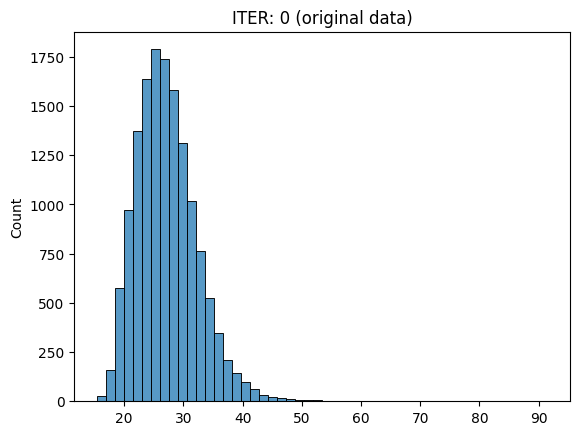

Saving the dataset (0/1 shards):   0%|          | 0/14436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

ITER: 0
initial THRESHOLD: 38.10969333648681
retained objects num: 14436
ITER: 1
retained objects num before: 14436
retained objects num after: 14002


1it [00:05,  5.07s/it]


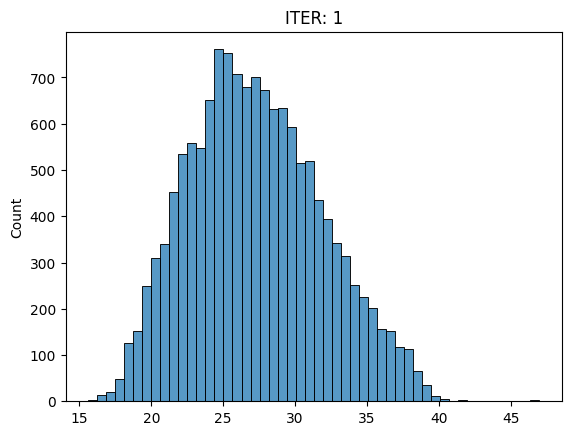

Saving the dataset (0/1 shards):   0%|          | 0/14002 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.04876074
ITER: 2
retained objects num before: 14002
retained objects num after: 13865


1it [00:04,  4.99s/it]


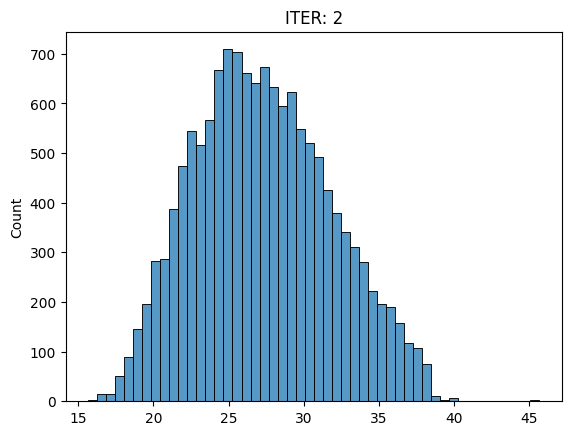

Saving the dataset (0/1 shards):   0%|          | 0/13865 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.015584908
ITER: 3
retained objects num before: 13865
retained objects num after: 13809


1it [00:04,  4.96s/it]


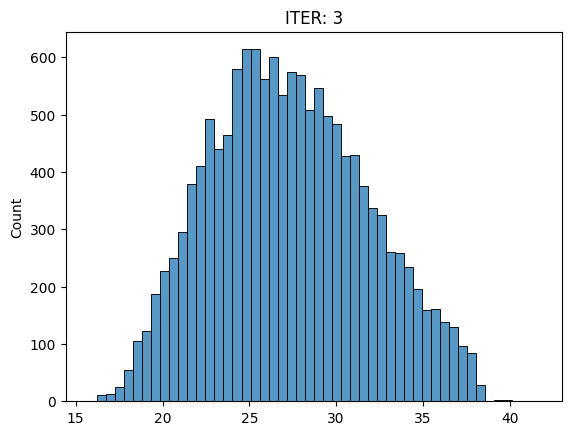

Saving the dataset (0/1 shards):   0%|          | 0/13809 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0066824756
ITER: 4
retained objects num before: 13809
retained objects num after: 13781


1it [00:05,  5.06s/it]


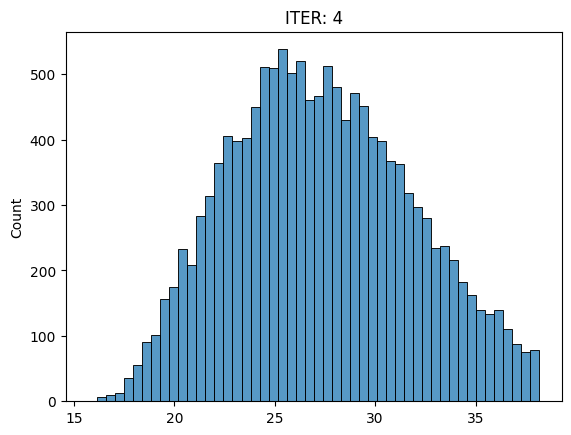

Saving the dataset (0/1 shards):   0%|          | 0/13781 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0033559578
ITER: 5
retained objects num before: 13781
retained objects num after: 13773


1it [00:04,  4.72s/it]


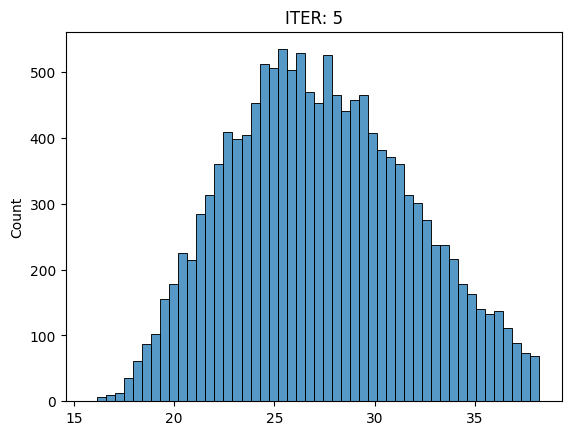

Saving the dataset (0/1 shards):   0%|          | 0/13773 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0013706234
ITER: 6
retained objects num before: 13773
retained objects num after: 13771


1it [00:04,  4.76s/it]


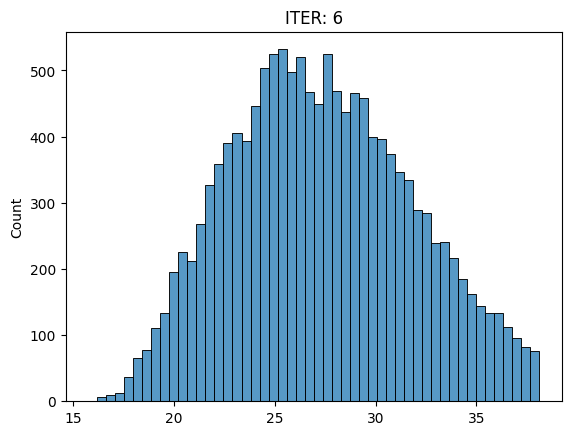

Saving the dataset (0/1 shards):   0%|          | 0/13771 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0004919258
ITER: 7
retained objects num before: 13771
retained objects num after: 13771


1it [00:04,  4.75s/it]


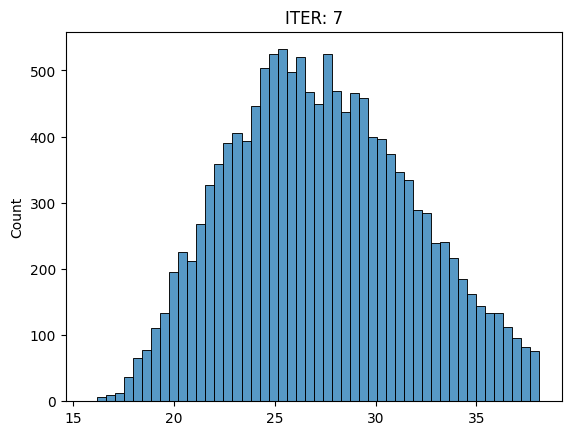

Saving the dataset (0/1 shards):   0%|          | 0/13771 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0


In [37]:
train_features = text_embeddings
train_labels = np.zeros(len(train_features))
eval_features = text_embeddings

centroids, centroids_mask = compute_centroids(train_features, train_labels)
sigma_inv = compute_inv_covariance(centroids, train_features, train_labels)[0]
dists = mahalanobis_distance_with_known_centroids_sigma_inv(centroids, centroids_mask, sigma_inv, eval_features).squeeze().numpy()

sns.histplot(dists, bins=50).set(title='ITER: 0 (original data)')
plt.show()

retained_objects = np.ones(train_features.shape[0], dtype=np.bool)

# save original dataset
filtered_data = deepcopy(raw_data)
filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
filtered_data.save_to_disk(f"{dataset_name}_filtered_data_new_{quantile}/iter_0.hf")

THRESHOLD = np.quantile(dists, quantile)
print("ITER:", 0)
print('initial THRESHOLD:', THRESHOLD)
print('retained objects num:', retained_objects.sum().item())

for i in range(1, MAX_ITER):
    print('======================================')
    print("ITER:", i)
    print('retained objects num before:', retained_objects.sum().item())
    retained_objects[retained_objects == 1] = (retained_objects[retained_objects == 1] * \
                                              (dists < THRESHOLD))
    print('retained objects num after:', retained_objects.sum().item())
    
    train_features = text_embeddings[retained_objects]
    train_labels = torch.zeros(len(train_features))
    eval_features = text_embeddings[retained_objects]
    new_centroids, new_centroids_mask = compute_centroids(train_features, train_labels)
    new_sigma_inv = compute_inv_covariance(new_centroids, train_features, train_labels)[0]
    dists = mahalanobis_distance_with_known_centroids_sigma_inv(new_centroids, new_centroids_mask, new_sigma_inv, eval_features).squeeze().numpy()
    # THRESHOLD = np.quantile(dists, quantile)
    # print('THRESHOLD:', THRESHOLD)
    sns.histplot(dists, bins=50).set(title='ITER: %i' % (i))
    plt.show()

    # save semi-filtered dataset
    filtered_data = deepcopy(raw_data)
    filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
    filtered_data.save_to_disk(f"{dataset_name}_filtered_data_new_{quantile}/iter_{i}.hf")

    centroids_diff = np.linalg.norm(new_centroids - centroids)
    
    centroids = new_centroids
    centroids_mask = new_centroids_mask
    sigma_inv = new_sigma_inv
    
    print('centroids distance:', centroids_diff)
    print('======================================')
    
    if centroids_diff < EPS:
        break

In [34]:
# retained_objects = np.ones(len(df), dtype=bool)

# train_features = text_embeddings[retained_objects]
# train_labels = np.zeros(np.sum(retained_objects))
# eval_features = text_embeddings[retained_objects]

# centroids, centroids_mask = compute_centroids(train_features, train_labels)
# sigma_inv = compute_inv_covariance(centroids, train_features, train_labels)

# for i in range(MAX_ITER):
#     print('======================================')
#     print("ITER:", i)
#     print('======================================')

#     retained_dists = mahalanobis_distance_with_known_centroids_sigma_inv(centroids, centroids_mask, sigma_inv, eval_features)

#     sns.histplot(retained_dists, bins=50)
#     plt.show()

# #     print(retained_objects.sum())
# #     print('retained_objects.shape:', retained_objects.shape)
# #     print('dists.shape:', dists.shape)
#     print('retained objects num before:', retained_objects.sum())
#     retained_objects[retained_objects == 1] = retained_objects[retained_objects == 1] * (retained_dists < THRESHOLD)
#     print('retained objects num after:', retained_objects.sum())

 
#     # cur_dists = mahalanobis_distance(text_embeddings[retained_objects],
#     #                                  np.zeros(np.sum(retained_objects)),
#     #                                  text_embeddings[retained_objects])
    
#     train_features = text_embeddings[retained_objects]
#     train_labels = np.zeros(np.sum(retained_objects))
#     eval_features = text_embeddings[retained_objects]

#     new_centroids, new_centroids_mask = compute_centroids(train_features, train_labels)
#     sigma_inv = compute_inv_covariance(new_centroids, train_features, train_labels)

#     centroids_diff_norm = np.linalg.norm(new_centroids - centroids)
#     print('centroids_diff_norm:', centroids_diff_norm)
#     if centroids_diff_norm < EPS:
#         break
    
#     centroids = new_centroids
#     centroids_mask = new_centroids_mask

In [33]:
filtered_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 13317
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1906
    })
})

In [37]:
# from datasets import DatasetDict, Dataset
# from copy import deepcopy

# filtered_data = deepcopy(raw_data)
# filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
# filtered_data

In [26]:
# # save filtered data to disk

# filtered_data.save_to_disk(dataset_name + "_filtered_data.hf")

In [35]:
# from datasets import DatasetDict, Dataset
# from copy import deepcopy

# filtered_data.save_to_disk(dataset_name + "_filtered_data.hf")
# filtered_data = deepcopy(raw_data)
# filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
# filtered_data

# Fine-tuning for summarization task

Предполагаемый пайплайн:
1. AESLC BERT (берт, unsupervised (на MLM task) дообученный на AESLC) --> эмбеддинги входных текстов (видимо, как усреденные пословные)
2. На полученных примерах считаем центроиды и ков. матрицу
3. Считаем расстояние Махаланобиса от центроидов 
4. Откидываем далекие примеры по трешхолду
5. Пересчитываем центроиды и ков. матрицу
6. Повторяем 2-6, пока центроиды меняются
7. Переучивыем модель для суммаризации на данных без выбросов и замеряем качество

In [6]:
# checkpoint_name = "facebook/bart-base"
checkpoint_name = "t5-small"

## Preprocess

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)

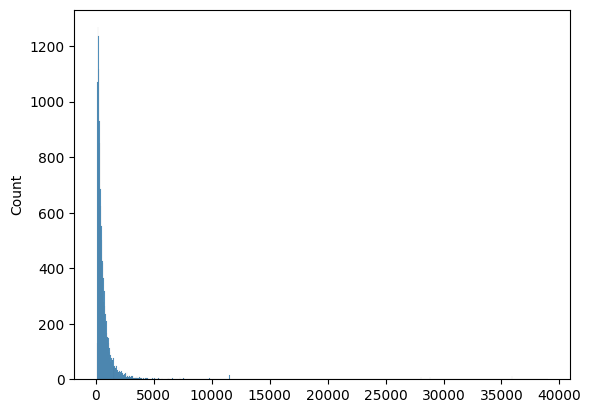

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

lens = list(map(len, raw_data['train']['text']))

sns.histplot(lens)
plt.show()

длины < 5000 --> max_length=1024 норм для токенайзера

In [9]:
# lens = list(map(len, raw_data['train']['summary']))

# sns.histplot(lens)
# plt.show()

In [10]:
def preprocess_function(examples):
    if checkpoint_name.split('/')[-1].split('-')[0] == 't5':
        prefix = "summarize: "
    else:
        prefix = ''
    
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding='max_length')

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True, padding='max_length')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
tokenized_orig_data = raw_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/14436 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/1906 [00:00<?, ? examples/s]

## Metrics

In [13]:
# ! pip install rouge_score --quiet

In [14]:
import evaluate

rouge = evaluate.load("rouge", cache_dir=CACHE_DIR_PATH)

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Original data

In [18]:
! wandb disabled

W&B disabled.


In [19]:
# ! pip install wandb --quiet

In [20]:
import wandb

original_run_name = dataset_name + "_original_" + checkpoint_name

wandb.login()
wandb.init(project='noise-in-abs-sum',
           name=original_run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [21]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

original_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_name)

In [22]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=original_model)

In [23]:
batch_size, eval_batch_size = 32, 64  # V100 config
# batch_size, eval_batch_size = 8, 16  # colab / local config

num_workers = 8

training_args = Seq2SeqTrainingArguments(
    output_dir=dataset_name + "-original-" + checkpoint_name,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="wandb", 
    dataloader_num_workers=num_workers,
)

In [24]:
trainer = Seq2SeqTrainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_orig_data["train"],
    eval_dataset=tokenized_orig_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [25]:
# train_model(original_model)
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` m

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
wandb.finish()

## Filtered data

In [38]:
import wandb

filtered_run_name = "filtered " + checkpoint_name + '_' + str(quantile)

wandb.login()
wandb.init(project='noise-in-abs-sum',
           name=filtered_run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vladimir_karlov. Use `wandb login --relogin` to force relogin


In [5]:
from datasets import load_from_disk

filtered_data = load_from_disk(dataset_name + "_filtered_data.hf")

wandb.log({'hyperparams/retained_obj_num' : filtered_data['train'].num_rows,
           # 'hyperparams/threshold' : THRESHOLD,
           'hyperparams/quantile' : quantile,
           'hyperparams/checkpoint_name' : checkpoint_name,
           'hyperparams/dataset_name' : dataset_name})

In [40]:
filtered_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 14064
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1906
    })
})

In [ ]:
import evaluate

rouge = evaluate.load("rouge", cache_dir=CACHE_DIR_PATH)

In [41]:
tokenized_filtered_data = filtered_data.map(preprocess_function, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

Loading cached processed dataset at filtered_data.hf/validation/cache-c4df093ac437e651.arrow
Loading cached processed dataset at filtered_data.hf/test/cache-911be88f74bb6f90.arrow


In [42]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

filtered_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_name)

In [43]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=filtered_model)

In [54]:
batch_size, eval_batch_size = 32, 64  # V100 config
# batch_size, eval_batch_size = 8, 16  # colab / local config

num_workers = 6

training_args = Seq2SeqTrainingArguments(
    output_dir=dataset_name + "-filtered-" + checkpoint_name.split('/')[-1] + '_' + str(quantile),
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="wandb", 
    dataloader_num_workers=num_workers,
    
)

In [55]:
trainer = Seq2SeqTrainer(
    model=filtered_model,
    args=training_args,
    train_dataset=tokenized_filtered_data["train"],
    eval_dataset=tokenized_filtered_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


In [ ]:
# train_model(filtered_model)
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, summary. If __index_level_0__, text, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14064
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1760
  Number of trainable parameters = 139420416
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BartTokenizerFast tokenizer. Please note that with a fa

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,4.406018,0.337400,0.182700,0.328400,0.328200,7.746100
2,3.108800,4.366955,0.337600,0.180100,0.329800,0.329500,7.658400
3,2.634500,4.321293,0.338300,0.178600,0.330500,0.330600,7.594400


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, text. If summary, text are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1906
  Batch size = 64
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to 

In [ ]:
wandb.finish()